In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import conda_installer
from rdkit import Chem
from deepchem.feat.graph_features import atom_features as get_atom_features
import rdkit
import pickle
import matplotlib.pyplot as plt
tf.data.experimental.enable_debug_mode()

2023-12-18 17:45:47.547395: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-18 17:45:47.753987: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-18 17:45:47.755990: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-18 17:45:48.616506: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
PDBs_folds = pickle.load(open('PDBs_folds_5.pkl', 'rb'))
y_folds = pickle.load(open('y_folds_5.pkl', 'rb'))
x_add_folds = pickle.load(open('x_add_folds_5.pkl', 'rb'))

In [12]:
%cd ../../PGGCN/

/home/ali/GBNN/PGGCN


In [14]:
import models.PGCN_model_entropy as pg
import importlib
importlib.reload(pg)

<module 'models.PGCN_model_entropy' from '/home/ali/GBNN/PGGCN/models/PGCN_model_entropy.py'>

In [ ]:
hists = []
predicts_train = []
predicts_test = []
loss = []
K = 5
for k in range(K):
    X_train = []
    x_add_train = []
    for i in range(K):
        if i != k:
            X_train += PDBs_folds[i]
            x_add_train += [np.array(x) for x in x_add_folds[i]]
    X_test = PDBs_folds[k]
    x_add_test = x_add_folds[i]
    y_train = np.concatenate(np.array([y_folds[i] for i in range(K) if i != k]), 0)
    y_test = np.array(y_folds[k])
    x_train_parsed = pg.data_generator(X_train, x_add_train)
    x_test_parsed = pg.data_generator(X_test, x_add_test)
    hs, m, x_converted = pg.get_trained_model(x_train_parsed, np.array(y_train), epochs=25)
    predicts_train.append(m.predict(x_converted, batch_size=len(X_train)))
    hists.append(hs)
    k_loss, x_converted = pg.test_model(x_test_parsed, y_test, m)
    loss.append(k_loss)
    predicts_test.append(m.predict(x_converted, batch_size=len(X_test)))
    

2023-12-18 17:52:23.323711: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/25
1/1 [==============================] - 86s 86s/step - loss: 1.8244
Epoch 2/25
1/1 [==============================] - 0s 370ms/step - loss: 1.8233
Epoch 3/25
1/1 [==============================] - 1s 733ms/step - loss: 1.8222
Epoch 4/25
1/1 [==============================] - 1s 715ms/step - loss: 1.8211
Epoch 5/25
1/1 [==============================] - 1s 689ms/step - loss: 1.8201
Epoch 6/25
1/1 [==============================] - 1s 693ms/step - loss: 1.8190
Epoch 7/25
1/1 [==============================] - 1s 693ms/step - loss: 1.8180
Epoch 8/25
1/1 [==============================] - 1s 701ms/step - loss: 1.8169
Epoch 9/25
1/1 [==============================] - 1s 715ms/step - loss: 1.8159
Epoch 10/25
1/1 [==============================] - 1s 686ms/step - loss: 1.8149
Epoch 11/25
1/1 [==============================] - 1s 689ms/step - loss: 1.8139
Epoch 12/25
1/1 [==============================] - 1s 691ms/step - loss: 1.8130
Epoch 13/25
1/1 [==============================] -

In [5]:
from dcFeaturizer import atom_features as get_atom_features
def featurize(molecule, info):
    
    atom_features = []
    for atom in molecule.GetAtoms():
        new_feature = get_atom_features(atom).tolist()
        position = molecule.GetConformer().GetAtomPosition(atom.GetIdx())
        new_feature += [atom.GetMass(), atom.GetAtomicNum()]
        new_feature += [position.x, position.y, position.z]
        for neighbor in atom.GetNeighbors()[:2]:
            neighbor_idx = neighbor.GetIdx()
            new_feature += [neighbor_idx]
        for i in range(2 - len(atom.GetNeighbors())):
            new_feature += [-1]
        atom_features.append(np.concatenate([new_feature, info], 0))
    return np.array(atom_features)

In [6]:
from PGCN_model_entropy import get_trained_model, test_model

In [8]:
X = []
y = []
for i, pdb in enumerate(list(PDBs.keys())):
    X.append(featurize(PDBs[pdb], info[i]))
    y.append(df[df['Id'] == pdb]['exp'].to_numpy()[0])

In [9]:
K = 4
fold_size = len(X) // K
X_folds = [X[i*fold_size:(i + 1)*fold_size] for i in range(K)]
y_folds = [y[i*fold_size:(i + 1)*fold_size] for i in range(K)]

In [ ]:
hists = []
test_loss = []
for k in range(K):
    X_train = []
    for i in range(K):
        if i != k:
            X_train += X_folds[i]
    X_test = X_folds[k]
    y_train = np.concatenate(np.array([y_folds[i] for i in range(K) if i != k]), 0)
    y_test = np.array(y_folds[k])
    hist, m = get_trained_model(X_train, y_train, epochs=20)
    hists.append(hist)
    test_loss.append(test_model(X_test, y_test, m))

Epoch 1/20


2023-04-07 15:45:47.204883: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-07 15:45:47.312748: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19680000 exceeds 10% of free system memory.
2023-04-07 15:46:49.759955: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19680000 exceeds 10% of free system memory.
2023-04-07 15:46:49.760100: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19680000 exceeds 10% of free system memory.
2023-04-07 15:46:49.760183: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19680000 exceeds 10% of free system memory.
2023-04-07 15:46:49.761308: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19680000 exceeds 10% of free system memory.


1/1 [==============================] - 63s 63s/step - loss: 6.9158
Epoch 2/20
1/1 [==============================] - 0s 257ms/step - loss: 7.4083
Epoch 3/20
1/1 [==============================] - 1s 517ms/step - loss: 6.8534
Epoch 4/20
1/1 [==============================] - 1s 565ms/step - loss: 4.2013
Epoch 5/20
1/1 [==============================] - 1s 571ms/step - loss: 5.7269
Epoch 6/20
1/1 [==============================] - 1s 516ms/step - loss: 6.2983
Epoch 7/20
1/1 [==============================] - 1s 514ms/step - loss: 5.0216
Epoch 8/20
1/1 [==============================] - 1s 640ms/step - loss: 3.8203
Epoch 9/20
1/1 [==============================] - 1s 546ms/step - loss: 4.4421
Epoch 10/20
1/1 [==============================] - 1s 541ms/step - loss: 5.1593
Epoch 11/20
1/1 [==============================] - 1s 557ms/step - loss: 4.5454
Epoch 12/20
1/1 [==============================] - 1s 579ms/step - loss: 4.2135
Epoch 13/20
1/1 [==============================] - 0s 473ms/s

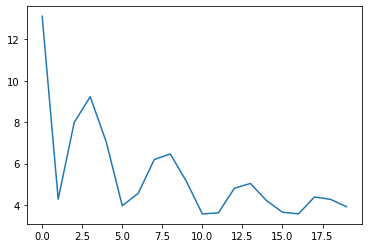

In [9]:
plt.plot(hist.history['loss'])

In [11]:
input_shapes = []
y_test = y[int(.8*len(X)):]
for i in range(len(X_test)):
    input_shapes.append(np.array(X_test[i]).shape[0])
m.set_input_shapes(input_shapes)
for i in range(len(X_test)):
    if X_test[i].shape[0] < 2000:
        new_list = np.zeros([2000 - X_test[i].shape[0], 41])
        X_test[i] = np.concatenate([X_test[i], new_list], 0)
X_test = np.array(X_test)
y_test = np.array(y_test)
m.evaluate(X_test, y_test)

1/1 [==============================] - 6s 6s/step - loss: 5.1557


5.155716419219971